In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import category_encoders as ce

date_format = "%m/%d/%Y"

<h1>III. Data Preparation</h1>
<p>First, we will convert the dates column into numerical values. Then, we will create a MntTotal column that is the sum of all other monetary columns.</p>

In [2]:
def dataProcessing(file):
    df = pd.read_excel(file, index_col="Custid")
    # DROPING COLUMNS
    cols_to_drop = ["Year_Birth", "Dt_Customer", "Kidhome", "Teenhome", "MntLighting", "MntCameras", "MntDoor_Locks", "MntThermostats", "MntSecurity_Systems", "MntPremium", "Z_CostContact", "Z_Revenue", "MntTotal", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Education", "Marital_Status"]

    # Droping group info
    df.drop(['Group', 'Element1', 'Element2', 'Element3', 'Element4', 'Element5'], axis=1, inplace=True)

    #Creating columns for age and days as a Customer instead of using the regular values
    df['Age'] = 2020 - df['Year_Birth']
    df['DaysAsCustomer'] = (datetime.strptime('03/18/2021', date_format) - df['Dt_Customer']).dt.days

    #Changing the columns teenhome and kidhome to boolean
    df["Kidhome"] = np.where(df["Kidhome"] == 0, df["Kidhome"], 1)
    df["Teenhome"] = np.where(df["Teenhome"] == 0, df["Teenhome"], 1)
    #Creating new column to know if the person has kid, teen, both or none
    df["Children"] = df["Kidhome"] + df["Teenhome"]

    #Dealing with missing values
    #Income
    df['Income'] = df.groupby(['Education', 'Children'])['Income'].apply(lambda x: x.fillna(x.median()))
    #Filling NaN on MntSecurity_Systems and MntPremium by 0
    df['MntSecurity_Systems'].fillna(0, inplace=True)
    df['MntPremium'].fillna(0, inplace=True)
    
    #Preparation DF
    df_prep = df.copy(deep=True)

    #Loggin the Mnt Values
    df_prep["logLighting"] = np.where(df_prep["MntLighting"] == 0, df_prep["MntLighting"], np.log(df_prep["MntLighting"]))
    df_prep["logCameras"] = np.where(df_prep["MntCameras"] == 0, df_prep["MntCameras"], np.log(df_prep["MntCameras"]))
    df_prep["logDoor_Locks"] = np.where(df_prep["MntDoor_Locks"] == 0, df_prep["MntDoor_Locks"], np.log(df_prep["MntDoor_Locks"]))
    df_prep["logThermostats"] = np.where(df_prep["MntThermostats"] == 0, df_prep["MntThermostats"], np.log(df_prep["MntThermostats"]))
    df_prep["logSecurity_Systems"] = np.where(df_prep["MntSecurity_Systems"] == 0, df_prep["MntSecurity_Systems"], np.log(df_prep["MntSecurity_Systems"]))
    df_prep["logPremium"] = np.where(df_prep["MntPremium"] == 0, df_prep["MntPremium"], np.log(df_prep["MntPremium"]))

    #Creating a column with the sum of the Mnt Values
    df_prep["MntTotal"] = df_prep["MntLighting"] + df_prep["MntCameras"] + df_prep["MntDoor_Locks"] + df_prep["MntThermostats"] + df_prep["MntSecurity_Systems"] + df_prep["MntPremium"]
    df_prep["logTotal"] = df_prep["logLighting"] + df_prep["logCameras"] + df_prep["logDoor_Locks"] + df_prep["logThermostats"] + df_prep["logSecurity_Systems"] + df_prep["logPremium"]

    incomeCap = 150000
    df_prep = df_prep[df_prep["Income"] < incomeCap]

    #Summing the Acceptance Campaigns
    df_prep["AcceptCmpTotal"] = df_prep["AcceptedCmp2"] + df_prep["AcceptedCmp3"] + df_prep["AcceptedCmp4"] + df_prep["AcceptedCmp5"]

    #Encoding categorica columns
    # Enconding the columns that are strings or categorical
    colsToEncode = ["Education", "Marital_Status"]
    dummies = pd.get_dummies(df_prep[colsToEncode])
    df_prep = pd.concat([df_prep, dummies], axis=1)

    #Droping original columns
    df_prep.drop(cols_to_drop, axis=1, inplace=True)

    return df_prep

In [3]:
campaign = "Group35_SmartHome_Campaign.xlsx"

df_campaign = dataProcessing(campaign)

/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs

In [4]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2492 entries, 350001144 to 350011119
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Income                   2492 non-null   float64
 1   Recency                  2492 non-null   int64  
 2   NumDealsPurchases        2492 non-null   int64  
 3   NumWebPurchases          2492 non-null   int64  
 4   NumCatalogPurchases      2492 non-null   int64  
 5   NumStorePurchases        2492 non-null   int64  
 6   NumWebVisitsMonth        2492 non-null   int64  
 7   AcceptedCmp1             2492 non-null   int64  
 8   Complain                 2492 non-null   int64  
 9   DepVar                   2492 non-null   int64  
 10  Age                      2492 non-null   int64  
 11  DaysAsCustomer           2492 non-null   int64  
 12  Children                 2492 non-null   int64  
 13  logLighting              2492 non-null   float64
 14  logCameras 

<h1>Modeling</h1>

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import learning_curve
import category_encoders as ce
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#### Useful Functions

In [6]:
def get_revenue(y_test, y_pred, revenue, cost):
    from sklearn.metrics import confusion_matrix 
    cm = confusion_matrix(y_test, y_pred)
    total_revenue = (cm[1][1]) * revenue
    return total_revenue

In [7]:
def get_profit(y_test, y_pred, revenue, cost):
    from sklearn.metrics import confusion_matrix 
    cm = confusion_matrix(y_test, y_pred)
    total_cost = (cm[0][1] + cm[1][1]) * cost
    total_revenue = (cm[1][1]) * revenue
    profit = total_revenue - total_cost
    return profit

In [8]:
def get_cost(y_test, y_pred, revenue, cost):
    from sklearn.metrics import confusion_matrix 
    cm = confusion_matrix(y_test, y_pred)
    total_cost = (cm[0][1] + cm[1][1]) * cost
    return total_cost

In [9]:
def get_roi(y_test, y_pred, revenue, cost):
    from sklearn.metrics import confusion_matrix 
    cm = confusion_matrix(y_test, y_pred)
    total_cost = (cm[0][1] + cm[1][1]) * cost
    total_revenue = (cm[1][1]) * revenue
    roi = (total_revenue / total_cost) * 100
    return roi

In [10]:
def print_classification(y_test, y_pred_test):
    from sklearn.metrics import classification_report, confusion_matrix
    # Classification Report
    print(classification_report(y_test, y_pred_test))
    
    # Plot
    cm = confusion_matrix(y_test, y_pred_test)

    plt.figure(figsize = (5,3))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

<h3>X & y | Train/Test Split</h3>

In [11]:
X = df_campaign.copy(deep=True)

y = X["DepVar"]

In [12]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

# Remove the Target from the training
X_train = X_train.drop(['DepVar'],1)
X_test = X_test.drop(['DepVar'],1)

<h3>Scalle the Values</h3>

In [13]:
# Dataframe for scaling
tempDF = X.copy(deep=True)
tempDF.drop(columns='DepVar', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>Create Model</h3>

In [14]:
# Create object and train the model
classModel = LogisticRegression(random_state=123)
classModel.fit(X_train_scaled, y_train)

LogisticRegression(random_state=123)

<h3>Predictions (y_test, y_train)</h3>

In [15]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train_scaled) 
y_pred_test = classModel.predict(X_test_scaled) 

<h2>Evaluate the Model</h2>

<h3>Confusion Matrix</h3>

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1731
           1       0.44      0.76      0.56       138

    accuracy                           0.91      1869
   macro avg       0.71      0.84      0.75      1869
weighted avg       0.94      0.91      0.92      1869



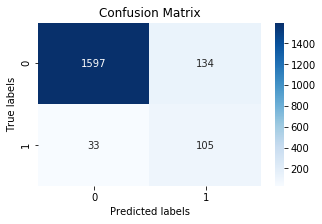

In [16]:
# TRAIN RESULTS
print_classification(y_pred_train,y_train)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       543
           1       0.83      0.49      0.61        80

    accuracy                           0.92       623
   macro avg       0.88      0.74      0.79       623
weighted avg       0.92      0.92      0.91       623



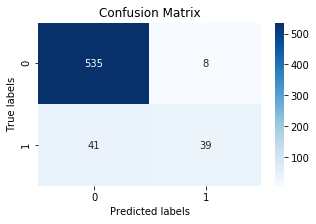

In [17]:
# TEST RESULTS
print_classification(y_test,y_pred_test)

<h3>ROI Analysis</h3>

In [18]:
cm = confusion_matrix(y_test,y_pred_test)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

print('False Positive Rate (Lower the better): {} %'.format(FP/(TN + FP)*100))
print('False Negative Rate (Lower the better): {} %'.format(FN/(TP + FN)*100))

False Positive Rate (Lower the better): 1.4732965009208103 %
False Negative Rate (Lower the better): 51.24999999999999 %


In [19]:
# Analysing the share of users impacted and conversions captured

impactedClients = TP + FP
impactedConversion = TP
allConversion = TP + FN
allClients = len(X_test)

print('Share of selected clients: {} %'.format(impactedClients / allClients * 100))
print('Share of conversions predicted: {} %'.format(impactedConversion / allConversion * 100))

Share of selected clients: 7.54414125200642 %
Share of conversions predicted: 48.75 %


In [20]:
cost = 4
revenue = 14

In [21]:
# By default [Sending everycustomer an promotion]

defaultCampaign = (sum(y_test)*revenue) - (cost * len(X_test))
defaultROI = ((sum(y_test)*revenue) / (cost * len(X_test))) * 100

print('Total Cost: {} €'.format(cost * len(X_test)))
print('Total Revenue: {} €'.format(sum(y_test)*revenue))
print('Total Profit: {} €'.format(defaultCampaign))
print('ROI: {}%'.format(defaultROI))

Total Cost: 2492 €
Total Revenue: 1120 €
Total Profit: -1372 €
ROI: 44.9438202247191%


In [22]:
# By applying the model

linearRegProfit = get_profit(y_test = y_test, y_pred = y_pred_test, revenue = revenue, cost = cost)
linearRegROI = get_roi(y_test = y_test, y_pred = y_pred_test, revenue = revenue, cost = cost)
linearRegCost = get_cost(y_test = y_test, y_pred = y_pred_test, revenue = revenue, cost = cost)
linearRegRevenue = get_revenue(y_test = y_test, y_pred = y_pred_test, revenue = revenue, cost = cost)

print('Total Cost: {} €'.format(linearRegCost))
print('Total Revenue: {} €'.format(linearRegRevenue))
print('Total Profit: {} €'.format(linearRegProfit))
print('ROI: {}%'.format(linearRegROI))

Total Cost: 188 €
Total Revenue: 546 €
Total Profit: 358 €
ROI: 290.4255319148936%



<h3>Measures of Performance</h3>

In [23]:
# Function to calculate MAPE metric
def mean_absolute_percentage_error(y_true, y_pred_test): 
    y_true, y_pred_test = np.array(y_true), np.array(y_pred_test)
    return np.mean(np.abs((y_true - y_pred_test) / y_true)) * 100

In [24]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [25]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Measure,Train,Test
0,MAE,0.089353,0.078652
1,RMSE,0.298919,0.280449
2,R^2,0.198801,0.297261
3,MAPE (%),NaN,NaN
4,MAX Error,1.000000,1.000000


In [26]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain)]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [27]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.910647,0.921348
1,PRECISION,0.760870,0.829787
2,RECALL,0.439331,0.487500


In [28]:
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

In [29]:
svc = SVC(random_state=123)
svc.fit(X_train,y_train)

SVC(random_state=123)

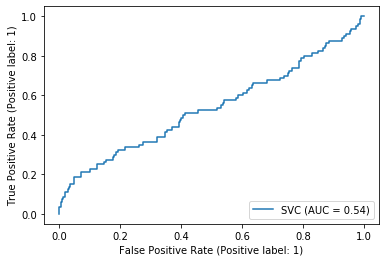

In [30]:
svc_disp = plot_roc_curve(svc, X_test, y_test)
plt.show()

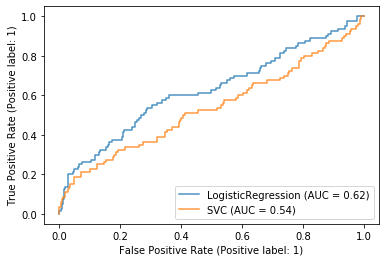

In [31]:
classModel = LogisticRegression(random_state=123)
classModel.fit(X_train,y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(classModel, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()